# Welcome to Gleeo time analysis notebook

This notebook comes with a tutorial, see [this blog post](http://jacqueskaiser.com/posts/2019/12/gleeo-plotter).

To get started, copy the file **"Time Tracker data export.csv"** next to this notebook and run the cells.

In [13]:
%autosave 0
%matplotlib inline
import pandas as pd
import numpy as np
# Set ipython's max row display
pd.set_option('display.max_row', 10)

# Set iPython's max column width
pd.set_option('display.max_columns', 10)

# Matplotlib defaults
from pylab import rcParams
rcParams['figure.figsize'] = (15,7)
rcParams['font.size'] = 15

Autosave disabled


In [14]:
time_entries = pd.read_csv("Time Tracker data export.csv")
time_entries['Start'] = pd.to_datetime(time_entries['Start'])
time_entries['End'] = pd.to_datetime(time_entries['End'])

In [15]:
time_entries

,Domain,Project,Task,Details,Start,...,Decimal Duration,Project-Extra-1,Project-Extra-2,Task-Extra-1,Task-Extra-2
0,work,administrative,mail,NaN,2019-01-02 09:23:00,...,0.250000,NaN,NaN,NaN,NaN
1,work,research,writing,NaN,2019-01-02 09:38:00,...,2.766667,NaN,NaN,NaN,NaN
2,other,break,lunch,NaN,2019-01-02 12:24:00,...,0.683333,NaN,NaN,NaN,NaN
3,work,research,writing,NaN,2019-01-02 13:05:00,...,5.033333,NaN,NaN,NaN,NaN
4,work,administrative,mail,NaN,2019-01-03 10:13:00,...,0.116667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1506,work,research,hardware,NaN,2019-12-20 09:14:00,...,0.266667,NaN,NaN,NaN,NaN
1507,work,administrative,meeting,NaN,2019-12-20 09:30:00,...,1.083333,NaN,NaN,NaN,NaN
1508,work,research,hardware,NaN,2019-12-20 10:35:00,...,1.666667,NaN,NaN,NaN,NaN
1509,other,break,lunch,NaN,2019-12-20 12:15:00,...,1.083333,NaN,NaN,NaN,NaN


In [16]:
projects = time_entries['Project'].unique()
tasks = time_entries['Task'].unique()
print("Projects: {}".format(projects))
print("Tasks: {}".format(tasks))

Projects: ['administrative' 'research' 'break' 'industry' 'public']
Tasks: ['mail' 'writing' 'lunch' 'teaching' 'thesis' 'projectA' 'meeting'
 'student' 'paperwork' 'lab course' 'machine learning' 'reading'
 'projectB' 'presentation' 'travel' 'conference' 'demonstration'
 'maintenance' 'coffee' 'tours' 'seminar' 'eventB' 'platform dev'
 'training' 'vision' 'environment' 'eventA' 'fair' 'workshop' 'hardware']


# Total time spent on projects

All times are displayed in **hours**.

In [17]:
project_total = time_entries.groupby('Project').sum()
project_total["Decimal Duration"]

Project
administrative    434.516667
break             158.566667
industry          530.433333
public            195.533333
research          806.933333
Name: Decimal Duration, dtype: float64

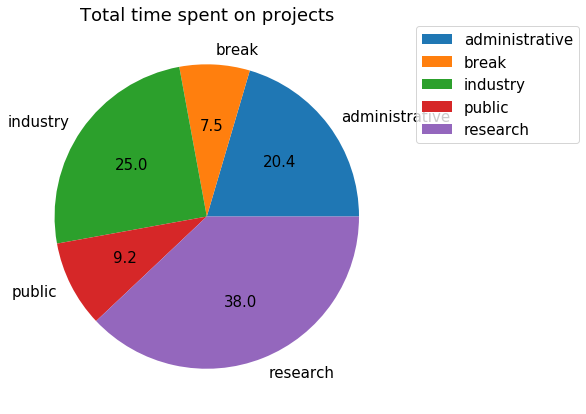

In [18]:
ax = project_total.plot.pie(y='Decimal Duration', autopct='%.1f')
ax.set_title('Total time spent on projects')
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Time spent on projects per unit of time

In [19]:
start = time_entries.iloc[0]['Start'].round('D')
end = time_entries.iloc[-1]['End'].round('D')
years = range(start.year, end.year+1)
print("Tracking period from {} to {}".format(start, end))

Tracking period from 2019-01-02 00:00:00 to 2019-12-21 00:00:00


In [20]:
def get_time_spent_per(time_unit):
    plt_time_index = pd.date_range(start, end, freq = time_unit)
    range_df = pd.DataFrame(plt_time_index, index=plt_time_index, columns=['Date'])
    range_df['End'] = range_df['Date'].shift(-1)
    range_df = range_df.iloc[:-1] # drop last range

    series = [ time_entries.loc[(time_entries['Start'] > row['Date']) & (time_entries['End'] < row['End'])]\
        .groupby('Project')['Decimal Duration'].sum()
     for _, row in range_df.iterrows() ]
    organized_durations = pd.DataFrame(series, index=range_df['Date']).fillna(0)
    return organized_durations

## per month

Average hours/month: 181.71833333333333


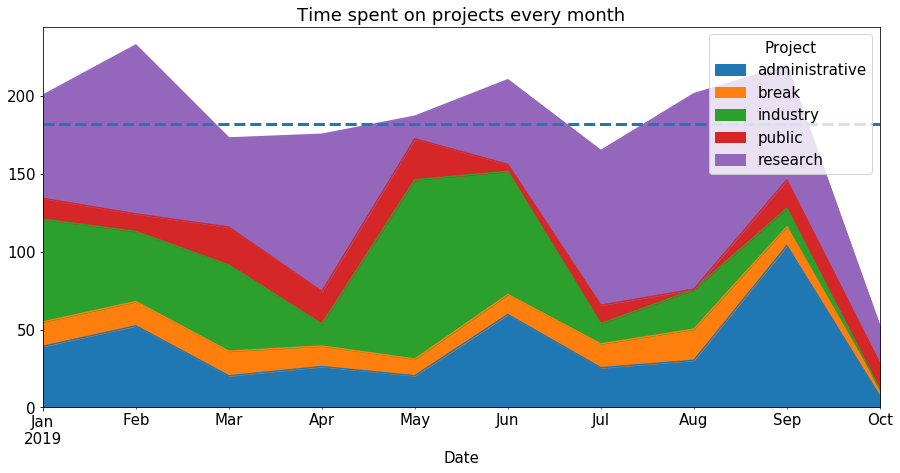

In [21]:
df_month = get_time_spent_per("BM")
ax = df_month.plot.area(title="Time spent on projects every month")
average_hours_per_month = df_month.mean().sum()
print("Average hours/month: {}".format(average_hours_per_month))
ax.axhline(average_hours_per_month, linestyle="--", linewidth=3)

¶# Time spent on projects every week

## per week

Average hours/week: 41.968707482993196


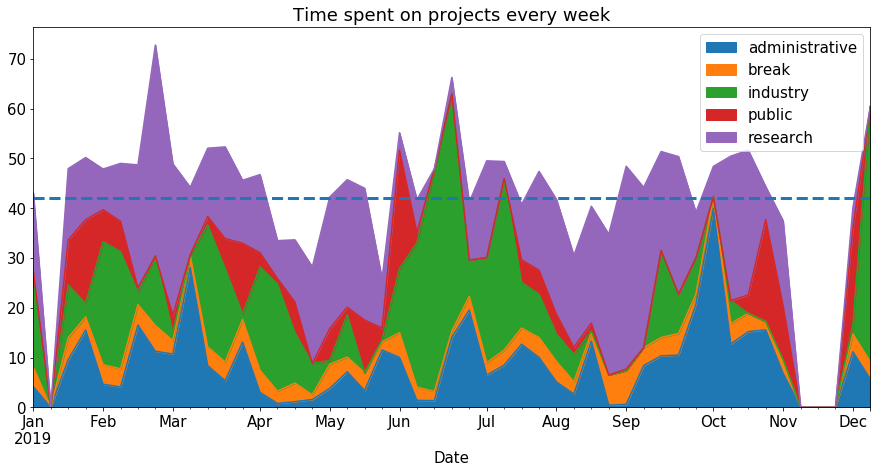

In [22]:
df_week = get_time_spent_per("W")
ax = df_week.plot.area(title="Time spent on projects every week")
average_hours_per_week = df_week.mean().sum()
print("Average hours/week: {}".format(average_hours_per_week))
ax.axhline(average_hours_per_week, linestyle="--", linewidth=3)

# Overhours

To calculate the amount of overhours, append your vacations in the file `personal/holidays.yaml`.
Provide your state vacations to the holidays library.

In [23]:
import holidays
import yaml

state_vacation = holidays.Germany(prov='BW', years=years)
state_vacation_dates = list(state_vacation.keys())

vacation_dates = [] + state_vacation_dates
personal_vacations = yaml.load(open('personal/holidays.yaml', 'r'))
vacation_count = 0
for vacation in personal_vacations:
    date_range = pd.bdate_range(start=vacation['from'], end=vacation['to'], freq='C',
                                name=vacation['name'], holidays=state_vacation_dates)
    print('{} used up {} vacation days'.format(vacation['name'], len(date_range)))
    vacation_count += len(date_range)
    vacation_dates += date_range.tolist()
print('Total number of holiday days taken: {}'.format(vacation_count))

Snowboard in the alps used up 5 vacation days
WOOFing in an organic farm used up 2 vacation days
Permaculture training used up 15 vacation days
Total number of holiday days taken: 22


/home/jkaiser/miniconda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


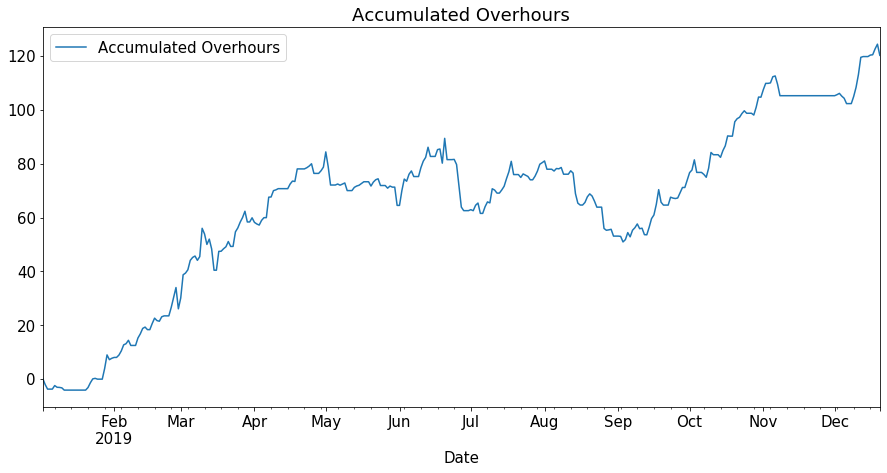

In [24]:
business_dates = pd.bdate_range(start, end, freq='C', holidays=vacation_dates)
business_df = pd.DataFrame(39.5 / 5., columns=['Expected hours'], index=business_dates)

worked_days = get_time_spent_per('D').drop('break', axis=1)
worked_df = pd.DataFrame(worked_days.sum(axis=1), columns=['Worked hours'])

overhours_df = pd.merge(business_df, worked_df, how='right', left_index=True, right_index=True).fillna(0)
overhours_df['Overhours'] = overhours_df['Worked hours'] - overhours_df['Expected hours']
overhours_df['Accumulated Overhours'] = overhours_df['Overhours'].cumsum()
overhours_df.plot(title="Accumulated Overhours", y=['Accumulated Overhours'])
